In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

tar=4
path='./Number'
# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    files = np.array(data['filenames'])
    targets = np_utils.to_categorical(np.array(data['target']), tar)
    return files, targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset(path)

test_files=train_files
test_targets = train_targets

# get the burn classes
# We only take the characters from a starting position to remove the path
#burn_classes = [item[11:-1] for item in sorted(glob(path))]
burn_classes = [item[9:-1] for item in sorted(glob("./Number/*/"))]
print(burn_classes)
# print statistics about the dataset
print('There are %d total categories.' % len(burn_classes))
print(burn_classes)
print('There are %s total burn images.\n' % len(np.hstack([train_files, test_files])))
print('There are %d training images.' % len(train_files))
print('There are %d test images.'% len(test_files))

for file in train_files: assert('.DS_Store' not in file)


['forward', 'none', 'reverse', 'stop']
There are 4 total categories.
['forward', 'none', 'reverse', 'stop']
There are 624 total burn images.

There are 312 training images.
There are 312 test images.


In [2]:
from keras.preprocessing import image                  
from tqdm import tqdm

# Note: modified these two functions, so that we can later also read the inception tensors which 
# have a different format 
def path_to_tensor(img_path, width=224, height=224):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(width, height))
    # convert PIL.Image.Image type to 3D tensor with shape (width, heigth, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, width, height, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths, width=224, height=224):
    list_of_tensors = [path_to_tensor(img_path, width, height) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [3]:
import keras
import timeit

# graph the history of model.fit
def show_history_graph(history):
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show() 


In [4]:
# callback to show the total time taken during training and for each epoch
class EpochTimer(keras.callbacks.Callback):
    train_start = 0
    train_end = 0
    epoch_start = 0
    epoch_end = 0
    
    def get_time(self):
        return timeit.default_timer()

    def on_train_begin(self, logs={}):
        self.train_start = self.get_time()
 
    def on_train_end(self, logs={}):
        self.train_end = self.get_time()
        print('Training took {} seconds'.format(self.train_end - self.train_start))
 
    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_start = self.get_time()
 
    def on_epoch_end(self, epoch, logs={}):
        self.epoch_end = self.get_time()
        print('Epoch {} took {} seconds'.format(epoch, self.epoch_end - self.epoch_start))

In [5]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255


100%|███████████████████████████████████████████████████████████████████████████████| 312/312 [00:01<00:00, 186.37it/s]


In [6]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.models import Model
from keras.callbacks import ModelCheckpoint 

import matplotlib.pyplot as plt

img_width, img_height = 224, 224
batch_size = 8
num_classes = 4
epoch=25




In [7]:
img_width, img_height = img_width, img_height
batch_size = 32
samples_per_epoch = 10
validation_steps = 300
nb_filters1 = 32
nb_filters2 = 64
conv1_size = 3
conv2_size = 3
pool_size = 3
classes_num = 4
lr = 0.0004

In [8]:
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, Activation
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras import callbacks
import time

#input_shape=(img_width, img_height,3)
model = Sequential()
model.add(Convolution2D(nb_filters1, conv1_size, conv1_size, padding='same', input_shape=(img_width, img_height, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

model.add(Convolution2D(nb_filters2, conv2_size, conv2_size, padding='same'))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))
model.add(Flatten())
model.add(Dense(256))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(tar, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=lr),
              metrics=['accuracy'])

hist=model.fit(train_tensors, train_targets ,validation_split=0.1, epochs=epoch, batch_size=64)

test_loss, test_acc = model.evaluate(train_tensors, train_targets)

y_pred=model.predict(test_tensors)

Epoch 1/25
5/5 [==============================] - 3s 588ms/step - loss: 1.3142 - accuracy: 0.3893 - val_loss: 1.1929 - val_accuracy: 0.4688
Epoch 2/25
5/5 [==============================] - 1s 249ms/step - loss: 1.1226 - accuracy: 0.5500 - val_loss: 1.0278 - val_accuracy: 0.7188
Epoch 3/25
5/5 [==============================] - 1s 218ms/step - loss: 0.9875 - accuracy: 0.7143 - val_loss: 0.8836 - val_accuracy: 0.6250
Epoch 4/25
5/5 [==============================] - 1s 223ms/step - loss: 0.8554 - accuracy: 0.7214 - val_loss: 0.7787 - val_accuracy: 0.7188
Epoch 5/25
5/5 [==============================] - 1s 222ms/step - loss: 0.7672 - accuracy: 0.7714 - val_loss: 0.6024 - val_accuracy: 0.8750
Epoch 6/25
5/5 [==============================] - 1s 223ms/step - loss: 0.6767 - accuracy: 0.8250 - val_loss: 0.5254 - val_accuracy: 0.9062
Epoch 7/25
5/5 [==============================] - 1s 236ms/step - loss: 0.6060 - accuracy: 0.8536 - val_loss: 0.4829 - val_accuracy: 0.9062
Epoch 8/25
5/5 [====

In [9]:
print(test_loss, test_acc)

0.06316523998975754 0.9935897588729858


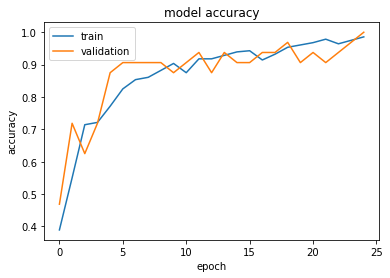

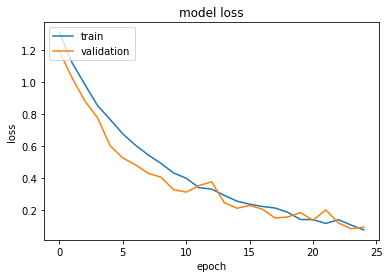

In [10]:
show_history_graph(hist)

In [11]:
from sklearn.metrics import confusion_matrix,accuracy_score
cm = confusion_matrix(np.argmax(test_targets, axis=1),np.argmax(y_pred, axis=1))

accuracydnn = accuracy_score(np.argmax(test_targets, axis=1),np.argmax(y_pred, axis=1))
print("SB_DNN confusion matrics=",cm)
print("  ")
print("SB_DNN accuracy=",accuracydnn*100)

SB_DNN confusion matrics= [[ 80   0   0   0]
 [  0 103   0   0]
 [  1   1  67   0]
 [  0   0   0  60]]
  
SB_DNN accuracy= 99.35897435897436


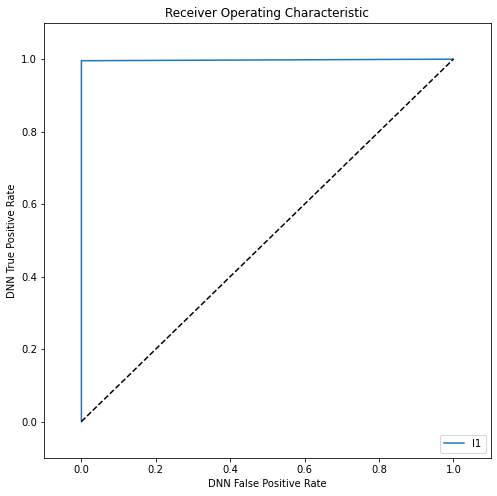

In [12]:
from sklearn.metrics import roc_curve
# Calculate ROC curve from y_test and pred
fpr, tpr, thresholds = roc_curve(np.argmax(test_targets, axis=1)>=1,np.argmax(y_pred, axis=1)>=1)



# Plot the ROC curve
fig = plt.figure(figsize=(8,8))
plt.title('Receiver Operating Characteristic')

# Plot ROC curve
plt.plot(fpr, tpr, label='l1')
plt.legend(loc='lower right')

# Diagonal 45 degree line
plt.plot([0,1],[0,1],'k--')

# Axes limits and labels
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('DNN True Positive Rate')
plt.xlabel('DNN False Positive Rate')
plt.show()

In [ ]:
#model.save('color_trained_modelDNN.h5')
model.save('trained_modelDNN.h5')
